In [1]:
!pip install -qU "numpy<2.0" "opencv-python-headless==4.10.*"
!pip install -qU ultralytics --no-deps
!pip install sahi
!pip install python-chess

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [2]:
# =============================================================================
# CELL 2: Imports and Configuration
# =============================================================================
import cv2
import numpy as np
import json
import pandas as pd
from pathlib import Path
from collections import Counter, deque
from typing import List, Dict, Tuple, Optional, Deque
from dataclasses import dataclass
import chess
from ultralytics import YOLO

# Try to import SAHI (optional)
try:
    from sahi import AutoDetectionModel
    from sahi.predict import get_sliced_prediction
    SAHI_AVAILABLE = True
except ImportError:
    SAHI_AVAILABLE = False

# =============================================================================
# Configuration - MATCHES analyze_chess_video_v4.py EXACTLY
# =============================================================================
CORNER_MODEL_PATH = "/kaggle/input/digiimg-model/pytorch/default/1/corner_detector/corner_detector/weights/corner_detect_best.pt"
PIECE_MODEL_PATH = "/kaggle/input/digiimg-model/pytorch/default/1/chess_models/chess_models/chess_detector_balanced/weights/best.pt"
BOARD_SIZE = 800
GRID_MARGIN = 35
WINDOW_SIZE = 15           # EXACT match with v4
CONFIDENCE_THRESHOLD = 0.8  # EXACT match with v4
USE_SAHI = False           # Disable SAHI for speed (avoid 8-slice prediction)

# =============================================================================
# PieceDetection Dataclass
# =============================================================================
@dataclass
class PieceDetection:
    """Single piece detection"""
    class_id: int
    class_name: str
    confidence: float
    x_center: float  # Normalized
    y_center: float
    width: float
    height: float
    
    @property
    def color(self) -> str:
        if 'white' in self.class_name.lower():
            return 'white'
        elif 'black' in self.class_name.lower():
            return 'black'
        return 'unknown'
    
    @property
    def piece_type(self) -> str:
        return self.class_name.replace('white-', '').replace('black-', '')


# =============================================================================
# DetectedMove Dataclass
# =============================================================================
@dataclass
class DetectedMove:
    """Detected chess move with metadata"""
    from_square: str
    to_square: str
    piece_type: str
    piece_color: str
    captured_piece: Optional[Tuple[str, str]] = None
    is_castling: bool = False
    is_promotion: bool = False
    promotion_piece: Optional[str] = None
    uci: str = ""
    san: str = ""
    confidence: str = "visual"  # "visual", "validated", "forced"
    
    def __str__(self):
        if self.is_castling:
            return "O-O" if self.to_square in ['g1', 'g8'] else "O-O-O"
        
        notation = f"{self.from_square}-{self.to_square}"
        if self.captured_piece:
            notation += f" (captures {self.captured_piece[1]} {self.captured_piece[0]})"
        if self.is_promotion:
            notation += f"={self.promotion_piece}"
        return notation


# =============================================================================
# ChessBoardSystem Class - EXACT copy from chess_board_system.py
# =============================================================================
class ChessBoardSystem:
    """
    Complete chess board detection and analysis system
    """
    
    def __init__(
        self,
        corner_model_path: str,
        piece_model_path: str,
        board_size: int = 800,
        use_sahi: bool = False,
        slice_size: int = 640,
        overlap_ratio: float = 0.2,
        grid_margin: int = 35,
        verbose: bool = False
    ):
        self.board_size = board_size
        self.grid_margin = grid_margin
        self.use_sahi = use_sahi and SAHI_AVAILABLE
        self.slice_size = slice_size
        self.overlap_ratio = overlap_ratio
        self.verbose = verbose
        
        self.locked_rotation = None
        
        if self.verbose:
            print(f"Loading corner model: {corner_model_path}")
        self.corner_model = YOLO(corner_model_path)
        
        if self.verbose:
            print(f"Loading piece model: {piece_model_path}")
        if self.use_sahi:
            self.piece_model = AutoDetectionModel.from_pretrained(
                model_type='yolov8',
                model_path=piece_model_path,
                confidence_threshold=0.3,
                device='cuda'
            )
        else:
            self.piece_model = YOLO(piece_model_path)
        
        self.square_grid = self._create_square_grid()
        if self.verbose:
            print("✅ Chess Board System initialized")
    
    def lock_orientation(self, rotation: int):
        if self.verbose:
            print(f"🔒 Locking board orientation to {rotation}°")
        self.locked_rotation = rotation
        
    def unlock_orientation(self):
        self.locked_rotation = None

    def _create_square_grid(self) -> Dict:
        usable_size = self.board_size - (2 * self.grid_margin)
        square_size = usable_size / 8
        
        grid = {}
        files = 'abcdefgh'
        ranks = '12345678'
        
        for rank_idx, rank in enumerate(ranks):
            for file_idx, file_letter in enumerate(files):
                square_name = f"{file_letter}{rank}"
                x1 = self.grid_margin + (file_idx * square_size)
                y1 = self.grid_margin + ((7 - rank_idx) * square_size)
                x2 = x1 + square_size
                y2 = y1 + square_size
                
                grid[square_name] = {
                    'bbox': (int(x1), int(y1), int(x2), int(y2)),
                    'center': (int((x1 + x2) / 2), int((y1 + y2) / 2)),
                    'file': file_letter,
                    'rank': rank
                }
        
        return grid
    
    def detect_corners(self, frame: np.ndarray, conf: float = 0.01) -> Optional[np.ndarray]:
        results = self.corner_model(frame, conf=conf, verbose=False)
        
        corners = []
        for result in results:
            for box in result.boxes:
                x, y = box.xywhn[0][:2].cpu().numpy()
                confidence = float(box.conf[0])
                corners.append({'x': x, 'y': y, 'conf': confidence})
        
        if len(corners) < 4:
            return None
        
        quadrants = {'tl': [], 'tr': [], 'br': [], 'bl': []}
        
        for c in corners:
            if c['x'] < 0.5 and c['y'] < 0.5:
                quadrants['tl'].append(c)
            elif c['x'] >= 0.5 and c['y'] < 0.5:
                quadrants['tr'].append(c)
            elif c['x'] >= 0.5 and c['y'] >= 0.5:
                quadrants['br'].append(c)
            else:
                quadrants['bl'].append(c)
        
        board_corners = []
        for quad in ['tl', 'tr', 'br', 'bl']:
            if not quadrants[quad]:
                return None
            best = max(quadrants[quad], key=lambda c: c['conf'])
            board_corners.append([best['x'], best['y']])
        
        return np.float32(board_corners)
    
    def detect_pieces(self, frame: np.ndarray, conf: float = 0.3) -> List[PieceDetection]:
        pieces = []
        
        if self.use_sahi:
            result = get_sliced_prediction(
                frame,
                self.piece_model,
                slice_height=self.slice_size,
                slice_width=self.slice_size,
                overlap_height_ratio=self.overlap_ratio,
                overlap_width_ratio=self.overlap_ratio
            )
            
            h, w = frame.shape[:2]
            for obj in result.object_prediction_list:
                bbox = obj.bbox
                x_center = (bbox.minx + bbox.maxx) / 2 / w
                y_center = (bbox.miny + bbox.maxy) / 2 / h
                width = (bbox.maxx - bbox.minx) / w
                height = (bbox.maxy - bbox.miny) / h
                
                pieces.append(PieceDetection(
                    class_id=obj.category.id,
                    class_name=obj.category.name,
                    confidence=obj.score.value,
                    x_center=x_center,
                    y_center=y_center,
                    width=width,
                    height=height
                ))
        else:
            results = self.piece_model(frame, conf=conf, verbose=False)
            
            for result in results:
                for box in result.boxes:
                    cls_id = int(box.cls[0])
                    confidence = float(box.conf[0])
                    x, y, w, h = box.xywhn[0].cpu().numpy()
                    
                    pieces.append(PieceDetection(
                        class_id=cls_id,
                        class_name=result.names[cls_id],
                        confidence=confidence,
                        x_center=float(x),
                        y_center=float(y),
                        width=float(w),
                        height=float(h)
                    ))
        
        return pieces
    
    def detect_orientation(self, pieces: List[PieceDetection]) -> Tuple[int, Dict]:
        if self.locked_rotation is not None:
            return self.locked_rotation, {'confidence': 'locked', 'rotation': self.locked_rotation}
            
        if not pieces:
            return 0, {'confidence': 'none', 'reason': 'no_pieces'}
        
        white_pieces = [p for p in pieces if p.color == 'white']
        black_pieces = [p for p in pieces if p.color == 'black']
        
        if not white_pieces or not black_pieces:
            return 0, {'confidence': 'low', 'reason': 'missing_colors'}
        
        white_y_avg = np.mean([d.y_center for d in white_pieces])
        black_y_avg = np.mean([d.y_center for d in black_pieces])
        
        white_pawns = [d for d in white_pieces if 'pawn' in d.piece_type.lower()]
        black_pawns = [d for d in black_pieces if 'pawn' in d.piece_type.lower()]
        
        confidence = 'medium'
        
        if white_pawns and black_pawns:
            white_pawn_y = np.mean([d.y_center for d in white_pawns])
            black_pawn_y = np.mean([d.y_center for d in black_pawns])
            confidence = 'high'
        else:
            white_pawn_y = white_y_avg
            black_pawn_y = black_y_avg
        
        y_diff = white_pawn_y - black_pawn_y
        
        if abs(y_diff) < 0.1:
            white_x_avg = np.mean([d.x_center for d in white_pieces])
            black_x_avg = np.mean([d.x_center for d in black_pieces])
            rotation = 90 if white_x_avg > black_x_avg else 270
            confidence = 'medium'
        else:
            rotation = 0 if y_diff > 0 else 180
        
        metadata = {
            'rotation': rotation,
            'confidence': confidence,
            'white_avg_y': float(white_y_avg),
            'black_avg_y': float(black_y_avg),
            'y_difference': float(y_diff),
            'white_count': len(white_pieces),
            'black_count': len(black_pieces)
        }
        
        return rotation, metadata
    
    def apply_perspective_transform(
        self,
        frame: np.ndarray,
        corners: np.ndarray,
        rotation: int = 0
    ) -> Tuple[np.ndarray, np.ndarray]:
        h, w = frame.shape[:2]
        
        if corners.max() <= 1.0:
            corners_px = corners.copy()
            corners_px[:, 0] *= w
            corners_px[:, 1] *= h
        else:
            corners_px = corners
        
        dst = np.float32([
            [0, 0],
            [self.board_size, 0],
            [self.board_size, self.board_size],
            [0, self.board_size]
        ])
        
        if rotation == 90:
            dst = np.float32([
                [self.board_size, 0],
                [self.board_size, self.board_size],
                [0, self.board_size],
                [0, 0]
            ])
        elif rotation == 180:
            dst = np.float32([
                [self.board_size, self.board_size],
                [0, self.board_size],
                [0, 0],
                [self.board_size, 0]
            ])
        elif rotation == 270:
            dst = np.float32([
                [0, self.board_size],
                [0, 0],
                [self.board_size, 0],
                [self.board_size, self.board_size]
            ])
        
        matrix = cv2.getPerspectiveTransform(corners_px, dst)
        warped = cv2.warpPerspective(frame, matrix, (self.board_size, self.board_size))
        
        return warped, matrix
    
    def map_pieces_to_squares(
        self,
        pieces: List[PieceDetection],
        transform_matrix: np.ndarray,
        frame_shape: Tuple[int, int],
        rotation: int = 0
    ) -> Dict[str, Tuple[str, str]]:
        board_state = {}
        h, w = frame_shape
        offset_factor = 0.25
        
        for piece in pieces:
            if rotation == 180: 
                feat_x = piece.x_center
                feat_y = piece.y_center + (piece.height * offset_factor)
            elif rotation == 0:
                feat_x = piece.x_center
                feat_y = piece.y_center - (piece.height * offset_factor)
            elif rotation == 270:
                feat_x = piece.x_center + (piece.width * offset_factor)
                feat_y = piece.y_center
            elif rotation == 90:
                feat_x = piece.x_center - (piece.width * offset_factor)
                feat_y = piece.y_center
            else:
                feat_x = piece.x_center
                feat_y = piece.y_center + (piece.height * offset_factor)
            
            x_px = feat_x * w
            y_px = feat_y * h
            
            point = np.array([[[x_px, y_px]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, transform_matrix)[0][0]
            
            min_dist = float('inf')
            closest_square = None
            
            for square_name, square_data in self.square_grid.items():
                center = square_data['center']
                dist = np.linalg.norm(transformed - center)
                
                if dist < min_dist:
                    min_dist = dist
                    closest_square = square_name
            
            if closest_square and min_dist < (self.board_size // 8):
                board_state[closest_square] = (piece.piece_type, piece.color)
        
        return board_state
    
    def initialize_board_detection(
        self,
        cap,
        corner_conf: float = 0.01,
        max_attempts: int = 30,
        required_detections: int = 3
    ) -> Optional[Tuple]:
        """
        CRITICAL: Multi-frame corner detection - EXACT match with v4
        """
        if self.verbose:
            print("🔍 Initializing board detection (multi-frame corner detection)...")
        
        corner_detections = []
        rotation_detections = []
        
        start_pos = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        
        for attempt in range(max_attempts):
            ret, frame = cap.read()
            if not ret:
                break
            
            corners = self.detect_corners(frame, corner_conf)
            
            if corners is not None and len(corners) == 4:
                pieces = self.detect_pieces(frame, 0.3)
                rotation, _ = self.detect_orientation(pieces)
                
                corner_detections.append(corners)
                rotation_detections.append(rotation)
                
                if self.verbose:
                    print(f"   Frame {attempt+1}: ✅ 4 corners detected, rotation={rotation}°")
                
                if len(corner_detections) >= required_detections:
                    final_corners = corner_detections[-1]
                    rotation_counts = Counter(rotation_detections)
                    final_rotation = rotation_counts.most_common(1)[0][0]
                    
                    if self.verbose:
                        print(f"✅ Board initialized: 4 corners, rotation={final_rotation}° (from {len(corner_detections)} detections)")
                    
                    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
                    return final_corners, final_rotation
            else:
                if self.verbose:
                    print(f"   Frame {attempt+1}: ❌ Corner detection failed")
        
        if corner_detections:
            if self.verbose:
                print(f"⚠️ Using best available detection ({len(corner_detections)} successful frames)")
            final_corners = corner_detections[-1]
            rotation_counts = Counter(rotation_detections)
            final_rotation = rotation_counts.most_common(1)[0][0]
            cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
            return final_corners, final_rotation
        
        if self.verbose:
            print("❌ Failed to detect corners in any frame")
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        return None
    
    def process_frame(
        self,
        frame: np.ndarray,
        corner_conf: float = 0.01,
        piece_conf: float = 0.3,
        cached_corners: Optional[List] = None,
        cached_rotation: Optional[int] = None
    ) -> Optional[Dict]:
        if cached_corners is not None:
            corners = cached_corners
        else:
            corners = self.detect_corners(frame, corner_conf)
            if corners is None:
                return None
        
        pieces = self.detect_pieces(frame, piece_conf)
        
        if cached_rotation is not None:
            rotation = cached_rotation
            orientation_metadata = {'rotation': rotation, 'method': 'cached'}
        else:
            rotation, orientation_metadata = self.detect_orientation(pieces)
        
        board_image, transform_matrix = self.apply_perspective_transform(
            frame, corners, rotation
        )
        
        board_state = self.map_pieces_to_squares(
            pieces,
            transform_matrix,
            frame.shape[:2],
            rotation=rotation
        )
        
        return {
            'corners': corners,
            'pieces': pieces,
            'piece_count': len(pieces),
            'rotation': rotation,
            'orientation': orientation_metadata,
            'board_image': board_image,
            'transform_matrix': transform_matrix,
            'board_state': board_state,
            'square_grid': self.square_grid
        }


# =============================================================================
# MoveTracker Class - EXACT copy from move_tracker.py
# =============================================================================
class MoveTracker:
    def __init__(self, streak_threshold: int = 7, resync_threshold: float = 3.0):
        self.streak_threshold = streak_threshold
        self.resync_threshold = resync_threshold
        self.last_stable_state = {}
        self.candidate_state = None
        self.candidate_dict = None
        self.streak_count = 0
        self.candidate_start_time = None
        self.last_stable_time = None
        self.moves = []
    
    def _calculate_move(
        self, 
        old_state: Dict, 
        new_state: Dict,
        timestamp: float
    ) -> Optional[DetectedMove]:
        old_squares = set(old_state.keys())
        new_squares = set(new_state.keys())
        
        disappeared = old_squares - new_squares
        appeared = new_squares - old_squares
        
        # Scenario A: Normal Move
        if len(disappeared) == 1 and len(appeared) == 1:
            from_sq = list(disappeared)[0]
            to_sq = list(appeared)[0]
            piece_type, piece_color = old_state[from_sq]
            new_type, new_color = new_state[to_sq]
            
            is_promotion = False
            promotion_piece = None
            if piece_type == 'pawn':
                rank = int(to_sq[1])
                if (piece_color == 'white' and rank == 8) or \
                   (piece_color == 'black' and rank == 1):
                    is_promotion = True
                    promotion_piece = new_type
            
            if not is_promotion:
                if piece_type != new_type or piece_color != new_color:
                    # Rejected 'teleport' move - piece identity mismatch
                    return None
            
            captured = None
            if to_sq in old_state and old_state[to_sq][1] != piece_color:
                captured = old_state[to_sq]
            
            return DetectedMove(
                from_square=from_sq,
                to_square=to_sq,
                piece_type=piece_type,
                piece_color=piece_color,
                captured_piece=captured,
                is_promotion=is_promotion,
                promotion_piece=promotion_piece,
                uci=f"{from_sq}{to_sq}" + (promotion_piece[0].lower() if is_promotion and promotion_piece else "")
            )
        
        # Scenario B: Capture
        elif len(disappeared) == 1 and len(appeared) == 0:
            from_sq = list(disappeared)[0]
            piece_type, piece_color = old_state[from_sq]
            
            capture_sq = None
            for sq in new_state:
                if sq in old_state and old_state[sq] != new_state[sq]:
                    new_type, new_color = new_state[sq]
                    
                    is_promotion = False
                    if piece_type == 'pawn':
                        rank = int(sq[1])
                        if (piece_color == 'white' and rank == 8) or \
                           (piece_color == 'black' and rank == 1):
                            is_promotion = True
                    
                    if not is_promotion:
                        if new_type == piece_type and new_color == piece_color:
                            capture_sq = sq
                            break
                    else:
                        if new_color == piece_color:
                            capture_sq = sq
                            break
            
            if capture_sq:
                captured = old_state[capture_sq]
                
                is_promotion = False
                promotion_piece = None
                if piece_type == 'pawn':
                    rank = int(capture_sq[1])
                    if (piece_color == 'white' and rank == 8) or \
                       (piece_color == 'black' and rank == 1):
                        is_promotion = True
                        promotion_piece = new_state[capture_sq][0]

                return DetectedMove(
                    from_square=from_sq,
                    to_square=capture_sq,
                    piece_type=piece_type,
                    piece_color=piece_color,
                    captured_piece=captured,
                    is_promotion=is_promotion,
                    promotion_piece=promotion_piece,
                    uci=f"{from_sq}{capture_sq}" + (promotion_piece[0].lower() if is_promotion and promotion_piece else "")
                )
        
        # Scenario C: Castling
        elif len(disappeared) == 2 and len(appeared) == 2:
            disappeared_list = list(disappeared)
            appeared_list = list(appeared)
            
            king_moves = []
            for from_sq in disappeared_list:
                if old_state[from_sq][0] == 'king':
                    for to_sq in appeared_list:
                        if new_state[to_sq][0] == 'king':
                            king_moves.append((from_sq, to_sq, old_state[from_sq]))
            
            if king_moves:
                from_sq, to_sq, (piece_type, piece_color) = king_moves[0]
                from_file = ord(from_sq[0]) - ord('a')
                to_file = ord(to_sq[0]) - ord('a')
                
                if abs(to_file - from_file) == 2:
                    return DetectedMove(
                        from_square=from_sq,
                        to_square=to_sq,
                        piece_type='king',
                        piece_color=piece_color,
                        is_castling=True,
                        uci=f"{from_sq}{to_sq}"
                    )
        
        # Scenario D: Multiple squares changed - find best matching move
        # This handles detection noise where multiple squares flicker
        elif len(disappeared) > 0 and len(appeared) > 0:
            # Try to match disappeared pieces to appeared pieces by identity
            best_match = None
            best_distance = float('inf')
            
            for from_sq in disappeared:
                from_piece = old_state[from_sq]
                from_type, from_color = from_piece
                
                for to_sq in appeared:
                    to_piece = new_state[to_sq]
                    to_type, to_color = to_piece
                    
                    # Check if piece identity matches (same type and color)
                    if from_type == to_type and from_color == to_color:
                        # Calculate board distance (prefer closer moves)
                        from_file = ord(from_sq[0]) - ord('a')
                        from_rank = int(from_sq[1]) - 1
                        to_file = ord(to_sq[0]) - ord('a')
                        to_rank = int(to_sq[1]) - 1
                        distance = abs(to_file - from_file) + abs(to_rank - from_rank)
                        
                        # Validate move is physically possible for this piece type
                        file_diff = abs(to_file - from_file)
                        rank_diff = abs(to_rank - from_rank)
                        
                        is_valid_move = False
                        if from_type == 'pawn':
                            # Pawns: 1-2 forward, 1 diagonal for capture
                            if file_diff <= 1 and rank_diff <= 2:
                                is_valid_move = True
                        elif from_type == 'knight':
                            # Knights: L-shape (2+1 or 1+2)
                            if (file_diff == 2 and rank_diff == 1) or (file_diff == 1 and rank_diff == 2):
                                is_valid_move = True
                        elif from_type == 'king':
                            # King: 1 square any direction (or 2 for castling)
                            if file_diff <= 2 and rank_diff <= 1:
                                is_valid_move = True
                        else:
                            # Queen, Rook, Bishop: can move far
                            is_valid_move = True
                        
                        if is_valid_move and distance < best_distance:
                            best_distance = distance
                            best_match = (from_sq, to_sq, from_type, from_color)
            
            if best_match:
                from_sq, to_sq, piece_type, piece_color = best_match
                return DetectedMove(
                    from_square=from_sq,
                    to_square=to_sq,
                    piece_type=piece_type,
                    piece_color=piece_color,
                    uci=f"{from_sq}{to_sq}"
                )
            
            # Fallback: no matching piece found, skip this state change
            return None
        
        return None


# =============================================================================
# ChessLogicValidator Class - EXACT copy from move_tracker.py
# =============================================================================
class ChessLogicValidator:
    def __init__(self):
        self.board = chess.Board()
        self.move_count = 0
        self.rejected_moves = []
        
    def validate_move(self, move: DetectedMove, visual_board_state: Dict) -> Tuple[bool, str]:
        try:
            chess_move = chess.Move.from_uci(move.uci)
        except ValueError:
            return False, f"Invalid UCI format: {move.uci}"
        
        if chess_move in self.board.legal_moves:
            try:
                san = self.board.san(chess_move)
            except:
                san = str(move.uci)
                
            self.board.push(chess_move)
            self.move_count += 1
            move.san = san
            move.confidence = "validated"
            return True, "Legal move"
        else:
            reason = f"Illegal: {move.uci} not in legal moves for current position"
            self.rejected_moves.append((move, reason))
            return False, reason
    
    def force_resync(self, visual_board_state: Dict, verbose: bool = False) -> bool:
        try:
            fen = self._visual_state_to_fen(visual_board_state)
            self.board.set_fen(fen)
            if verbose:
                print(f"🔄 RESYNCED engine to FEN: {fen}")
            return True
        except Exception as e:
            # Resync failed silently
            return False
    
    def _visual_state_to_fen(self, state: Dict) -> str:
        board_array = [[None for _ in range(8)] for _ in range(8)]
        
        piece_symbols = {
            ('pawn', 'white'): 'P', ('knight', 'white'): 'N', ('bishop', 'white'): 'B',
            ('rook', 'white'): 'R', ('queen', 'white'): 'Q', ('king', 'white'): 'K',
            ('pawn', 'black'): 'p', ('knight', 'black'): 'n', ('bishop', 'black'): 'b',
            ('rook', 'black'): 'r', ('queen', 'black'): 'q', ('king', 'black'): 'k',
        }
        
        for square, piece_info in state.items():
            file = ord(square[0]) - ord('a')
            rank = int(square[1]) - 1
            symbol = piece_symbols.get(piece_info, '?')
            board_array[7 - rank][file] = symbol
        
        fen_rows = []
        for row in board_array:
            fen_row = ""
            empty_count = 0
            for cell in row:
                if cell is None:
                    empty_count += 1
                else:
                    if empty_count > 0:
                        fen_row += str(empty_count)
                        empty_count = 0
                    fen_row += cell
            if empty_count > 0:
                fen_row += str(empty_count)
            fen_rows.append(fen_row)
        
        piece_placement = "/".join(fen_rows)
        active_color = "w" if self.move_count % 2 == 0 else "b"
        fen = f"{piece_placement} {active_color} KQkq - 0 {(self.move_count // 2) + 1}"
        return fen


# =============================================================================
# MoveDetectorV4 Class - EXACT copy from move_detector_v4.py
# =============================================================================
class MoveDetectorV4:
    def __init__(
        self,
        system: ChessBoardSystem,
        window_size: int = 15,
        confidence_threshold: float = 0.8,
        use_validation: bool = True,
        verbose: bool = True
    ):
        self.system = system
        self.window_size = window_size
        self.confidence_threshold = confidence_threshold
        self.use_validation = use_validation
        
        self.state_buffer: Deque[str] = deque(maxlen=window_size)
        self.raw_states: Deque[Dict] = deque(maxlen=window_size)
        
        self.sure_states: List[Dict] = []
        self.detected_moves: List[DetectedMove] = []
        
        self.validator = ChessLogicValidator()
        self.tracker_helper = MoveTracker()
        
        self.current_consensus_hash = None
        self.consecutive_failures = 0
        self.failure_threshold = 10
        self.verbose = verbose

    def _log(self, msg, end="\n"):
        if self.verbose:
            print(msg, end=end)

    def process_video(self, video_path: str, debug_video_path: Optional[str] = None) -> List[DetectedMove]:
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        
        frame_idx = 0
        
        self._log(f"\n🔎 Starting Analysis (V4 - Voting Stability)")
        self._log(f"   Window Size: {self.window_size}")
        self._log(f"   Confidence: {self.confidence_threshold*100}%")
        self._log("="*60)
        
        # CRITICAL: Multi-frame initialization - EXACT match with v4
        board_init = self.system.initialize_board_detection(cap, max_attempts=30, required_detections=3)
        if board_init is None:
            self._log("❌ Failed to initialize board detection")
            return []
        
        cached_corners, cached_rotation = board_init

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
                
            result = self.system.process_frame(
                frame, 
                cached_corners=cached_corners,
                cached_rotation=cached_rotation
            )
            
            if result:
                self.consecutive_failures = 0
                
                current_state = result['board_state']
                state_hash = json.dumps(current_state, sort_keys=True)
                
                self.state_buffer.append(state_hash)
                self.raw_states.append(current_state)
                
                # Dynamic threshold: lower near end of video to catch last moves
                frames_remaining = total_frames - frame_idx
                if frames_remaining < self.window_size * 2:
                    # Near end: use 60% threshold instead of 80%
                    effective_threshold = 0.6
                else:
                    effective_threshold = self.confidence_threshold
                
                if len(self.state_buffer) == self.window_size:
                    consensus_hash, count = Counter(self.state_buffer).most_common(1)[0]
                    confidence = count / self.window_size
                    
                    if confidence >= effective_threshold:
                        if consensus_hash != self.current_consensus_hash:
                            consensus_state = None
                            for i, h in enumerate(self.state_buffer):
                                if h == consensus_hash:
                                    consensus_state = self.raw_states[i]
                                    break
                            
                            if self.sure_states:
                                prev_state = self.sure_states[-1]
                                prev_count = len(prev_state)
                                curr_count = len(consensus_state)
                                diff = curr_count - prev_count
                                
                                # Only process if piece count stays same (0) or decreases (-1 for capture)
                                # +1 means detection recovered a piece (not a real move)
                                if -1 <= diff <= 0:
                                    self._process_new_state(consensus_state, consensus_hash, frame_idx, fps)
                                elif diff > 0:
                                    # Skip recovery states silently
                                    pass
                                else:
                                    # diff < -1: Too many pieces lost (hand occlusion)
                                    pass
                            else:
                                self._process_new_state(consensus_state, consensus_hash, frame_idx, fps)
                                current_rotation = result.get('rotation', 0)
                                self.system.lock_orientation(current_rotation)
            else:
                self.consecutive_failures += 1
                
                if self.consecutive_failures >= self.failure_threshold:
                    if len(self.state_buffer) > 0:
                        self._log(f"\n⚠️  Detection lost for {self.consecutive_failures} frames. Clearing buffer...")
                        self.state_buffer.clear()
                        self.raw_states.clear()
                
            if frame_idx % 30 == 0:
                progress = frame_idx / cap.get(cv2.CAP_PROP_FRAME_COUNT) * 100
                self._log(f"\rProcessing... {progress:.1f}%", end="")
                
            frame_idx += 1
            
        cap.release()
        
        # END-OF-VIDEO FLUSH: Check for pending move in buffer
        # This catches the last move when video ends before window fills
        self._log(f"\n🔚 End-of-video check: buffer={len(self.state_buffer)}, sure_states={len(self.sure_states)}")
        
        if len(self.state_buffer) >= 3 and self.sure_states:  # Lowered to 3 frames minimum
            # Get top 2 most common states
            state_counts = Counter(self.state_buffer).most_common(2)
            
            for consensus_hash, count in state_counts:
                end_confidence = count / len(self.state_buffer)
                
                # Skip if this is already the current state
                if consensus_hash == self.current_consensus_hash:
                    self._log(f"   Skipping already-processed state ({count} frames)")
                    continue
                
                # Lower threshold: 40% for end-of-video
                if end_confidence >= 0.4:
                    self._log(f"   Checking candidate: {count}/{len(self.state_buffer)} frames ({end_confidence*100:.0f}% confidence)")
                    
                    consensus_state = None
                    for i, h in enumerate(self.state_buffer):
                        if h == consensus_hash:
                            consensus_state = self.raw_states[i]
                            break
                    
                    if consensus_state:
                        prev_state = self.sure_states[-1]
                        prev_count = len(prev_state)
                        curr_count = len(consensus_state)
                        diff = curr_count - prev_count
                        
                        self._log(f"   Piece count: {prev_count} -> {curr_count} (diff={diff})")
                        
                        # Only accept if piece count DECREASES or stays same
                        # +1 means detection recovered a piece (not a real move)
                        if -1 <= diff <= 0:
                            self._log(f"   ✅ Processing end-of-video state")
                            self._process_new_state(consensus_state, consensus_hash, frame_idx, fps)
                            break  # Only process one pending move
                        elif diff > 0:
                            self._log(f"   ⏭️ Skipping: piece count INCREASED (detection recovery, not a move)")
                            # Continue to check next candidate
                        else:
                            self._log(f"   ❌ Rejected: piece count change too large")
        
        self._log(f"\n✅ Processing complete. Detected {len(self.detected_moves)} moves.")
        return self.detected_moves

    def _process_new_state(self, consensus_state, consensus_hash, frame_idx, fps):
        self._log(f"\n🔒 New Sure State found at frame {frame_idx} (Pieces: {len(consensus_state)})")
        
        if not self.sure_states:
            self.sure_states.append(consensus_state)
            self.current_consensus_hash = consensus_hash
            
            try:
                fen = self.validator._visual_state_to_fen(consensus_state)
                self.validator.board.set_fen(fen)
                self._log(f"   Initial FEN: {fen}")
            except:
                pass
        else:
            prev_state = self.sure_states[-1]
            timestamp = frame_idx / fps
            
            # Debug: Show state differences
            old_squares = set(prev_state.keys())
            new_squares = set(consensus_state.keys())
            disappeared = old_squares - new_squares
            appeared = new_squares - old_squares
            changed = {sq for sq in old_squares & new_squares if prev_state[sq] != consensus_state[sq]}
            
            self._log(f"   State diff: disappeared={list(disappeared)}, appeared={list(appeared)}, changed={list(changed)}")
            
            move = self.tracker_helper._calculate_move(prev_state, consensus_state, timestamp)
            
            if move is None:
                self._log(f"   ⚠️ _calculate_move returned None - trying fallback")
                # Fallback: Try to find ANY valid move from state changes
                if len(disappeared) >= 1 and len(appeared) >= 1:
                    # Try all combinations to find a valid chess move
                    for from_sq in disappeared:
                        for to_sq in appeared:
                            test_uci = f"{from_sq}{to_sq}"
                            try:
                                chess_move = chess.Move.from_uci(test_uci)
                                if chess_move in self.validator.board.legal_moves:
                                    piece_type, piece_color = prev_state[from_sq]
                                    move = DetectedMove(
                                        from_square=from_sq,
                                        to_square=to_sq,
                                        piece_type=piece_type,
                                        piece_color=piece_color,
                                        uci=test_uci
                                    )
                                    self._log(f"   ✅ Fallback found legal move: {test_uci}")
                                    break
                            except:
                                pass
                        if move:
                            break
            
            if move:
                self._log(f"🎯 Potential Move: {move}")
                
                if self.use_validation:
                    is_valid, reason = self.validator.validate_move(move, consensus_state)
                    if is_valid:
                        self._log(f"   ✅ Validated: {move.san}")
                        self.detected_moves.append(move)
                        
                        # CHECK FOR CHAINED MOVE: If multiple pieces disappeared,
                        # there might be another move after this one
                        remaining_disappeared = [sq for sq in disappeared if sq != move.from_square]
                        if remaining_disappeared:
                            self._log(f"   🔗 Checking for chained move from: {remaining_disappeared}")
                            for from_sq in remaining_disappeared:
                                piece_info = prev_state.get(from_sq)
                                if not piece_info:
                                    continue
                                piece_type, piece_color = piece_info
                                
                                # Check legal moves from the UPDATED board (after first move)
                                # The piece disappeared, so find where it could have gone
                                legal_moves_from_sq = [m for m in self.validator.board.legal_moves if m.uci()[:2] == from_sq]
                                
                                self._log(f"   🔗 Legal moves from {from_sq}: {[m.uci() for m in legal_moves_from_sq]}")
                                self._log(f"   🔗 Board turn: {'White' if self.validator.board.turn else 'Black'}")
                                self._log(f"   🔗 Piece at {from_sq} in engine: {self.validator.board.piece_at(chess.parse_square(from_sq))}")
                                
                                if legal_moves_from_sq:
                                    # Prioritize moves to detected squares, but fall back to any legal move
                                    best_move = None
                                    
                                    # 1. Check current state
                                    for legal_move in legal_moves_from_sq:
                                        to_sq = legal_move.uci()[2:4]
                                        if to_sq in new_squares or to_sq in changed:
                                            best_move = legal_move
                                            self._log(f"   🔗 Found in current state: {best_move.uci()}")
                                            break
                                    
                                    # 2. If not found, check the BUFFER for where piece ends up
                                    if best_move is None and len(self.raw_states) > 0:
                                        # Look at the most recent raw state (which may have recovered pieces)
                                        latest_state = self.raw_states[-1]
                                        for legal_move in legal_moves_from_sq:
                                            to_sq = legal_move.uci()[2:4]
                                            if to_sq in latest_state:
                                                # Check if the piece at destination matches
                                                dest_piece = latest_state.get(to_sq)
                                                if dest_piece and dest_piece[0] == piece_type and dest_piece[1] == piece_color:
                                                    best_move = legal_move
                                                    self._log(f"   🔗 Found in buffer (recovered state): {best_move.uci()}")
                                                    break
                                    
                                    # 3. Prefer check moves (like Qb6+)
                                    if best_move is None:
                                        for legal_move in legal_moves_from_sq:
                                            self.validator.board.push(legal_move)
                                            is_check = self.validator.board.is_check()
                                            self.validator.board.pop()
                                            if is_check:
                                                best_move = legal_move
                                                self._log(f"   🔗 Found check move: {best_move.uci()}")
                                                break
                                    
                                    # 4. Last resort: first legal move
                                    if best_move is None:
                                        best_move = legal_moves_from_sq[0]
                                        self._log(f"   🔗 Using first legal move: {best_move.uci()}")
                                    
                                    to_sq = best_move.uci()[2:4]
                                    chained_move = DetectedMove(
                                        from_square=from_sq,
                                        to_square=to_sq,
                                        piece_type=piece_type,
                                        piece_color=piece_color,
                                        uci=best_move.uci()
                                    )
                                    
                                    # Get SAN before pushing
                                    try:
                                        chained_move.san = self.validator.board.san(best_move)
                                        self.validator.board.push(best_move)
                                        self.validator.move_count += 1
                                        self._log(f"   🔗 Chained move added: {chained_move.san}")
                                        self.detected_moves.append(chained_move)
                                    except Exception as e:
                                        self._log(f"   🔗 Chained move failed: {e}")
                        
                        self.sure_states.append(consensus_state)
                        self.current_consensus_hash = consensus_hash
                    else:
                        self._log(f"   ⚠️ Rejected: {reason}")
                        self._log("   🔄 Force Resync (Valid Piece Count State)")
                        self.validator.force_resync(prev_state)
                        
                        try:
                            chess_move = chess.Move.from_uci(move.uci)
                            if chess_move in self.validator.board.legal_moves:
                                move.san = self.validator.board.san(chess_move)
                                self.validator.board.push(chess_move)
                                self.validator.move_count += 1
                                move.confidence = "validated_after_resync"
                            else:
                                self.validator.force_resync(consensus_state)
                                move.san = self._uci_to_basic_san(move)
                                move.confidence = "forced"
                        except:
                            move.san = self._uci_to_basic_san(move)
                            move.confidence = "forced"
                            self.validator.force_resync(consensus_state)
                        
                        self.detected_moves.append(move)
                        self.sure_states.append(consensus_state)
                        self.current_consensus_hash = consensus_hash
                else:
                    self.detected_moves.append(move)
                    self.sure_states.append(consensus_state)
                    self.current_consensus_hash = consensus_hash
            else:
                self._log(f"   ❌ No valid move found from state change - skipping")
                self._log(f"      Legal moves: {[m.uci() for m in list(self.validator.board.legal_moves)[:10]]}...")
            
    def _uci_to_basic_san(self, move) -> str:
        piece_symbols = {
            'king': 'K', 'queen': 'Q', 'rook': 'R',
            'bishop': 'B', 'knight': 'N', 'pawn': ''
        }
        
        piece_symbol = piece_symbols.get(move.piece_type, '')
        
        if move.is_castling:
            notation = "O-O" if move.to_square[0] == 'g' else "O-O-O"
        else:
            notation = piece_symbol
            
            if move.captured_piece:
                if not piece_symbol:
                    notation += move.from_square[0]
                notation += 'x'
            
            notation += move.to_square
            
            if move.is_promotion and move.promotion_piece:
                promo_symbol = piece_symbols.get(move.promotion_piece, 'Q')
                notation += f'={promo_symbol}'
        
        try:
            if hasattr(self, 'validator') and self.validator:
                if self.validator.board.is_checkmate():
                    notation += '#'
                elif self.validator.board.is_check():
                    notation += '+'
        except:
            pass
        
        return notation


# =============================================================================
# Helper Functions - From submission_notebook.ipynb
# =============================================================================
def moves_to_pgn(moves: List[DetectedMove]) -> str:
    """
    Convert detected moves to PGN format with proper color-aware pairing.
    """
    if not moves:
        return ""
    
    pgn_parts = []
    move_number = 1
    i = 0
    
    while i < len(moves):
        current_move = moves[i]
        current_color = current_move.piece_color
        
        if current_color == 'white':
            white_san = current_move.san if current_move.san else f"{current_move.from_square}{current_move.to_square}"
            
            if i + 1 < len(moves) and moves[i + 1].piece_color == 'black':
                black_move = moves[i + 1]
                black_san = black_move.san if black_move.san else f"{black_move.from_square}{black_move.to_square}"
                pgn_parts.append(f"{move_number}. {white_san} {black_san}")
                i += 2
            else:
                pgn_parts.append(f"{move_number}. {white_san}")
                i += 1
            move_number += 1
        else:
            black_san = current_move.san if current_move.san else f"{current_move.from_square}{current_move.to_square}"
            pgn_parts.append(f"{move_number}. {black_san}")
            i += 1
            move_number += 1
    
    return " ".join(pgn_parts)


def create_submission_csv(video_results: Dict[str, str], output_path: str = 'submission.csv'):
    """
    Create submission CSV in the required format.
    """
    rows = []
    for video_name, pgn in video_results.items():
        rows.append({
            'row_id': video_name,
            'output': pgn if pgn else ""
        })
    
    df = pd.DataFrame(rows, columns=['row_id', 'output'])
    df.to_csv(output_path, index=False)
    
    print(f"\n💾 CSV saved to: {output_path}")
    print(f"   Total videos: {len(rows)}")
    
    return df

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
!pip install editdistance
!wget https://drive.google.com/uc?id=1a96Ei0hwfMvYUyUK-d0ZxvK6m6uSoAuR -O chess_solution_final_seen.csv

--2025-12-14 14:40:35--  https://drive.google.com/uc?id=1a96Ei0hwfMvYUyUK-d0ZxvK6m6uSoAuR
Resolving drive.google.com (drive.google.com)... 173.194.216.113, 173.194.216.139, 173.194.216.101, ...
Connecting to drive.google.com (drive.google.com)|173.194.216.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1a96Ei0hwfMvYUyUK-d0ZxvK6m6uSoAuR [following]
--2025-12-14 14:40:35--  https://drive.usercontent.google.com/download?id=1a96Ei0hwfMvYUyUK-d0ZxvK6m6uSoAuR
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.204.132, 2607:f8b0:400c:c15::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.204.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 963 [application/octet-stream]
Saving to: ‘chess_solution_final_seen.csv’

chess_solution_fina 100%[===================>]     963  --.-KB/s    in 0s      

2025-12-14 14:40:36 (

In [4]:
import subprocess

def download_file(url, filename=None):
    """
    Downloads a file from the specified URL using wget.

    Parameters:
        url (str): The URL of the file to download.
        output_directory (str, optional): The directory to save the downloaded file.
    """
    # Construct the wget command
    cmd = ['wget', url]
    if filename:
        cmd.extend(['-O', filename])

    try:
        # Execute the wget command
        print(cmd)
        subprocess.run(cmd, check=True)
        print(f"Downloaded {url} successfully.")
    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")


In [5]:
import os
import shutil

SOURCE_DIR = '/kaggle/input/chess-videos/Chess Detection Competition'
DEST_DIR = '/kaggle/working'

# Build a dictionary of all files inside SOURCE_DIR (recursive)
all_files = {}
for root, dirs, files in os.walk(SOURCE_DIR):
    for file in files:
        full_path = os.path.join(root, file)
        all_files[file] = full_path   # key = filename, value = full path

print(f"📁 Indexed {len(all_files)} files from input directory")

# Open CSV
with open('/kaggle/working/chess_solution_final_seen.csv', 'r') as f:
    _ = f.readline()  # skip header

    for line in f:
        file_name = line.strip().split(',')[0]

        if file_name in all_files:
            source_path = all_files[file_name]
            dest_path = os.path.join(DEST_DIR, file_name)

            print(f"📂 Copying: {file_name}")
            shutil.copy(source_path, dest_path)
        else:
            print(f"❌ Not found anywhere: {file_name}")

print("✅ Done copying all available videos.")

📁 Indexed 7 files from input directory
📂 Copying: 2_Move_rotate_student.mp4
📂 Copying: 2_move_student.mp4
📂 Copying: 4_Move_studet.mp4
📂 Copying: 6_Move_student.mp4
📂 Copying: 8_Move_student.mp4
📂 Copying: (Bonus)Long_Video_label.mp4
✅ Done copying all available videos.


In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# MAIN FUNCTION - chess_move (DO NOT CHANGE FUNCTION NAME)
# This function will be used for marking, do not change function name, 
# input parameters and return parameters of this function
# =============================================================================
def chess_move(video_name):
    # Input : video filename (.mp4)
    # Output : return string of Chess moves for video_name
    moves = ""
    i = 0
    
    # Create a VideoCapture object
    cap = cv2.VideoCapture(video_name)
    
    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error opening video file")
        return moves
    
    # Read and display frames until the video ends or 'q' is pressed
    while cap.isOpened():
        ret, frame = cap.read()
        if ret and i == 0:
            # Display only the first frame
            plt.imshow(frame[:,:,::-1])
            i += 1
        else:
            break
    
    # Release the video capture object and close display windows
    cap.release()
    
    # Write your code here to extract the move from the image
    try:
        # Initialize system with verbose=False to suppress logs
        system = ChessBoardSystem(
            corner_model_path=CORNER_MODEL_PATH,
            piece_model_path=PIECE_MODEL_PATH,
            board_size=BOARD_SIZE,
            grid_margin=GRID_MARGIN,
            use_sahi=USE_SAHI,
            verbose=False
        )
        
        system.unlock_orientation()
        
        # Create detector with verbose=False to suppress logs
        detector = MoveDetectorV4(
            system=system,
            window_size=WINDOW_SIZE,
            confidence_threshold=CONFIDENCE_THRESHOLD,
            use_validation=True,
            verbose=False
        )
        
        # Process video
        detected_moves = detector.process_video(str(video_name), debug_video_path=None)
        
        # Convert to PGN
        moves = moves_to_pgn(detected_moves)
        
    except Exception as e:
        print(f"Error processing {video_name}: {str(e)}")
    
    return moves

Error opening video file
your result: 
solution   : output
The edit distance between your results and solution is 0.0.
your result: 1. Qh4+ 2. g3
solution   : 1. Qh4+ 2. g3
The edit distance between your results and solution is 1.0.
your result: 1. Qh4+ 2. g3
solution   : 1. Qh4+ 2. g3
The edit distance between your results and solution is 1.0.
your result: 1. f4 2. Ng6 fxg3 3. Nxh8
solution   : 1. f4 2. Ng6 fxg3 3. Nxh8
The edit distance between your results and solution is 1.0.
your result: 1. Bxb5 2. Rxb5 b6 3. c4 Ne7 4. Rb2
solution   : 1. Bxb5 2. Rxb5 b6 3. c4 Ne7 4. Rb2
The edit distance between your results and solution is 1.0.
your result: 1. Qe6 Kd8 2. Qf7 c6 3. Qf2 cxd5 4. Qxa7 Rc8 5. Rxb4 Nc6 6. Qb6+
solution   : 1. Qe6 Kd8 2. Qf7 c6 3. Qf2 cxd5 4. Qxa7 Rc8 5. Rxb4 Nc6 6. Qb6+
The edit distance between your results and solution is 1.0.
your result: 1. f4 d5 2. Nf3 Bf5 3. Nc3 Nc6 4. Nxd5 e6 5. Ne3 Qh4+ 6. Nxh4 Nh6 7. Nhxf5 Nxf5 8. Nxf5 exf5 9. d4 Nxd4 10. Rxd4 Rd8 11. Qe5+ Kd

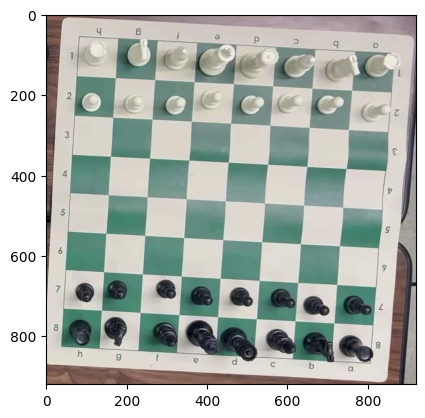

In [7]:
# =============================================================================
# CELL 3: Scoring (from submission_notebook.ipynb)
# =============================================================================
# Uncomment to run scoring:


import editdistance

f = open('/kaggle/working/chess_solution_final_seen.csv','r')
score = 0
n = 0
for line in f:
    video_name, moves_sol, p, link = line.split(',')
    moves = chess_move(video_name)
    s = 1 - editdistance.eval(moves, moves_sol) / max(len(moves), len(moves_sol))
    score += s
    #print(video_name)
    print(f"your result: {moves}")
    print(f"solution   : {moves_sol}")
    print(f"The edit distance between your results and solution is {s}.")
    n += 1
f.close()
if n != 0:
    print("-----------------------")
    print("Total score :", score/n)
    print("-----------------------")


Video: /kaggle/working/(Bonus)Long_Video_label.mp4
PGN: 1. f4 d5 2. Nf3 Bf5 3. Nc3 Nc6 4. Nxd5 e6 5. Ne3 Qh4+ 6. Nxh4 Nh6 7. Nhxf5 Nxf5 8. Nxf5 exf5 9. d4 Nxd4 10. Rxd4 Rd8 11. Qe5+ Kd7 12. Qxf5+ Kc6 13. g5 14. fxg5 Bb4+ 15. Qe6 16. Qf7 17. c3
Moves: 17


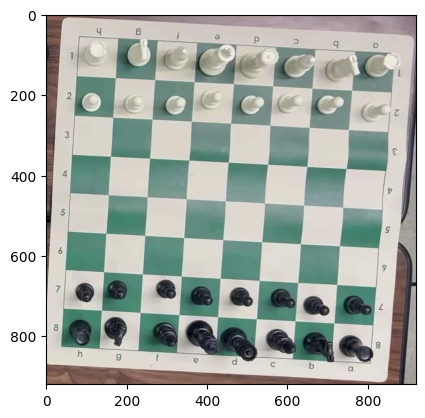

In [8]:
test_video = "/kaggle/working/(Bonus)Long_Video_label.mp4"  # Change this to your test video
result = chess_move(test_video)
print(f"Video: {test_video}")
print(f"PGN: {result}")
print(f"Moves: {result.count('.')}")

📁 Indexed 7 files from input directory
📂 Copying: 2_Move_rotate_student.mp4
📂 Copying: 2_move_student.mp4
📂 Copying: 4_Move_studet.mp4
📂 Copying: 6_Move_student.mp4
📂 Copying: 8_Move_student.mp4
📂 Copying: (Bonus)Long_Video_label.mp4
✅ Done copying all available videos.
\n🎬 Found 6 videos to process
\n[1/6] Processing: 2_move_student.mp4
  ✅ 3 moves
\n[2/6] Processing: 8_Move_student.mp4
  ✅ 7 moves
\n[3/6] Processing: 6_Move_student.mp4
  ✅ 5 moves
\n[4/6] Processing: 4_Move_studet.mp4
  ✅ 4 moves
\n[5/6] Processing: 2_Move_rotate_student.mp4
  ✅ 3 moves
\n[6/6] Processing: (Bonus)Long_Video_label.mp4
  ✅ 18 moves

💾 CSV saved to: /kaggle/working/submission.csv
   Total videos: 6
\n📋 Sample results:
                      row_id  \
0         2_move_student.mp4   
1         8_Move_student.mp4   
2         6_Move_student.mp4   
3          4_Move_studet.mp4   
4  2_Move_rotate_student.mp4   

                                              output  
0                                      1. 

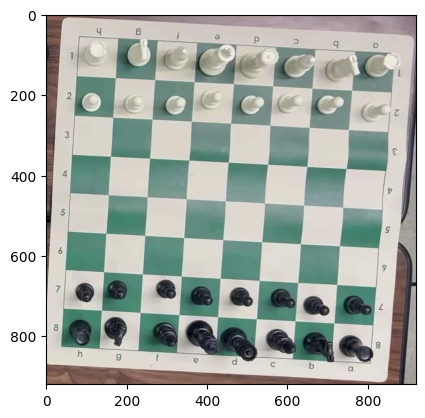

In [9]:
# =============================================================================
# CELL 4: Batch Process Videos (from submission_notebook.ipynb)
# =============================================================================
# Uncomment to run batch processing:

import os
import shutil

SOURCE_DIR = '/kaggle/input/chess-videos/Chess Detection Competition'
DEST_DIR = '/kaggle/working'

all_files = {}
for root, dirs, files in os.walk(SOURCE_DIR):
    for file in files:
        full_path = os.path.join(root, file)
        all_files[file] = full_path

print(f"📁 Indexed {len(all_files)} files from input directory")

with open('/kaggle/working/chess_solution_final_seen.csv', 'r') as f:
    _ = f.readline()  # skip header

    for line in f:
        file_name = line.strip().split(',')[0]

        if file_name in all_files:
            source_path = all_files[file_name]
            dest_path = os.path.join(DEST_DIR, file_name)

            print(f"📂 Copying: {file_name}")
            shutil.copy(source_path, dest_path)
        else:
            print(f"❌ Not found anywhere: {file_name}")

print("✅ Done copying all available videos.")



# =============================================================================
# CELL 5: Generate Submission CSV (from submission_notebook.ipynb)
# =============================================================================
# Uncomment to run:

def process_all_videos_to_csv(video_dir: str, output_csv: str = 'submission.csv'):
    video_dir = Path(video_dir)
    video_files = list(video_dir.glob("*.mp4")) + list(video_dir.glob("*.mov"))
    video_files = list(set(video_files))
    
    print(f"\\n🎬 Found {len(video_files)} videos to process")
    print("="*60)
    
    results = {}
    
    for idx, video_path in enumerate(video_files, 1):
        print(f"\\n[{idx}/{len(video_files)}] Processing: {video_path.name}")
        try:
            pgn = chess_move(str(video_path))
            results[video_path.name] = pgn
            print(f"  ✅ {len(pgn.split('.')) if pgn else 0} moves")
        except Exception as e:
            print(f"  ❌ Error: {str(e)}")
            results[video_path.name] = ""
    
    df = create_submission_csv(results, output_csv)
    print(f"\\n📋 Sample results:")
    print(df.head())
    
    return df

video_directory = "/kaggle/working/"
df = process_all_videos_to_csv(video_directory, "/kaggle/working/submission.csv")



In [10]:
import pandas as pd

df = pd.read_csv("/kaggle/working/submission.csv")
df['row_id'] = df['row_id'].str.strip()

old_name = "(Bonus)Long_Video_label.mp4"
new_name = "(Bonus)Long_video_student.mp4"

df.loc[df['row_id'] == old_name, 'row_id'] = new_name

if len(df[df['row_id'] == new_name]) > 0:
    print("SUCCESS: The name has been changed.")
else:
    print("WARNING: Name not found. Please check if the file path is correct.")

df.to_csv("/kaggle/working/final_submission.csv", index=False)

SUCCESS: The name has been changed.
